<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков " data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков </a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Выбор локации для скважины

По условиям задания мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищем месторождения, для каждого определяем значения признаков;
- Строим модель и оцениваем объём запасов;
- Выбираем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

При разведке региона исследуем 500 точек, из которых с помощью машинного обучения выбираем 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выберем регион с наибольшей средней прибылью.

# Описание данных

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

Загрузим данные для дальнейшего анализа и построения моделей прогнозирования.

In [ ]:
pip install -U pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats as st
from sklearn.metrics import mean_absolute_error

RANDOM_STATE = 12345
TOTAL_WELLS = 500 #общее количество рассматриваемых скважин
BEST_WELLS = 200 #количество лучших скважин
PROFIT_BARRELS = 450000 #прибыли с 1000 баррелей
BUDGET = 10000000000 #бюджет на разработку

pth0 = '/content/7_geo_data_0.csv'
pth0_1 = 'C:\geo_data_0.csv'
pth1 = '/content/7_geo_data_1.csv'
pth1_1 = 'C:\geo_data_1.csv'
pth2 = '/content/7_geo_data_2.csv'
pth2_1 = 'C:\geo_data_2.csv'
try:
    geo_data_0 = pd.read_csv(pth0)
    geo_data_1 = pd.read_csv(pth1)
    geo_data_2 = pd.read_csv(pth2)
except:
    geo_data_0 = pd.read_csv(pth0_1)
    geo_data_1 = pd.read_csv(pth1_1)
    geo_data_2 = pd.read_csv(pth2_1)


Создадим отчет по исследовательскому анализу данных из первого файла.

In [ ]:
ProfileReport(geo_data_0)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Посмотрим что из себя представляют данные для каждого из трех регионов.

In [ ]:
i = 1
for region in [geo_data_0, geo_data_1, geo_data_2]:
    print (f'Регион {i}')
    print (region.head())
    print ('')
    i+=1

Регион 1
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

Регион 2
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

Регион 3
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746



In [ ]:
i = 1
for region in [geo_data_0, geo_data_1, geo_data_2]:
    print (f'Регион {i}')
    print (region.info())
    print ('')
    i+=1

Регион 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Регион 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Регион 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (to

Как видим из полученных данных, каждая из трех таблиц имеет одинаковый набор данных, состоящий из id скважины ( катергориальный признак, от которого стоит избавиться при последующем моделировании), трех колонок с количественными признаками и одной колонки с целевым признаком `product`. Все колонки имеют одинаковое количество строк и не имеют пропусков.

Посмотрим на распределение данных в каждом датасете.

In [ ]:
i = 1
for region in [geo_data_0, geo_data_1, geo_data_2]:
    print (f'Регион {i}')
    print (region.describe())
    print ('')
    i+=1

Регион 1
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347

Регион 2
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      2

Данные распределены довольно равномерно, какие-либо экстремальные или неадеватные значения отстутствуют.

На всякий случай проверим, есть ли дублирующиеся строки в талицах с данными.

In [ ]:
i = 1
for region in [geo_data_0, geo_data_1, geo_data_2]:
    print (f'Регион {i}')
    print (region.duplicated().sum())
    print ('')
    i+=1

Регион 1
0

Регион 2
0

Регион 3
0



Таких строк не оказалось.

Методом `pairplot` определим есть ли мультиколлинеарность в каком-либо из датасетов.

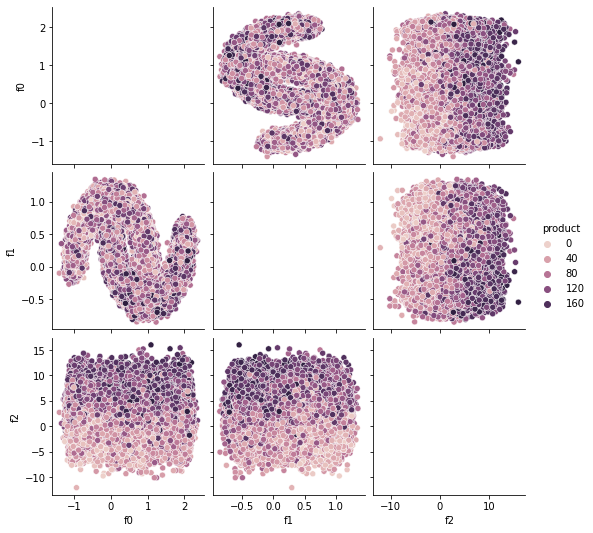

In [ ]:
sns.pairplot(geo_data_0, hue='product');

Признаков со схожей коллинеарностью в датасетах не оказалось. Для дальнейшей работы будем использовать все признаки. 

При помощи `boxplot`проверим наглядно еще раз как распределены данные целевого  и убедимся в отсутствии разбросов в данных.

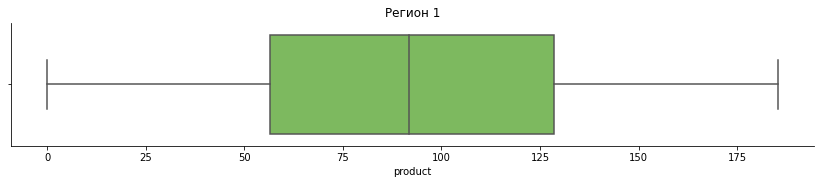

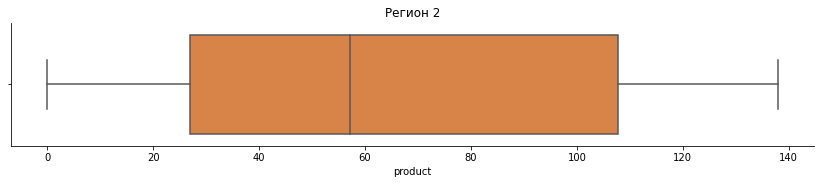

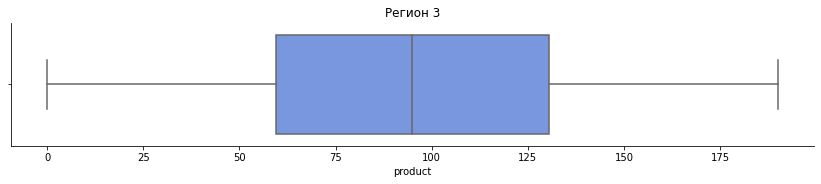

In [ ]:
count = 0
colors = ['#78C850', '#F08030', '#6890F0']
for df in [geo_data_0, geo_data_1, geo_data_2]:
    g = sns.catplot(x='product', kind='box',data = df, color = colors[count])
    g.fig.set_figwidth(12)
    g.fig.set_figheight(2)
    count+=1
    plt.title(f'Регион {count}') 
    

## Обучение и проверка модели

Построим модель линейной регрессии для каждого из трех регионов.

Для этого напишем функцию, которая разделит данные на основные и целевые признаки, а затем каждый полученный тип признаков в свою очередь на обучающую и валидационную выборки из соотношения 75:25. Обучим модель на обучающей выборке и получим предсказания на признаках валидационной выборки.



In [ ]:
def LinReg(region):
    target = region['product']
    features = region.drop(['product','id'] , axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=.25, random_state = RANDOM_STATE)
    model = LinearRegression()
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    return features_train, features_valid, target_train, target_valid, model, predicted_valid
i = 1
for region in [geo_data_0, geo_data_1, geo_data_2]:
    print (f'Регион {i}')
    LinReg(region)
    features_train, features_valid, target_train, target_valid, model, predicted_valid = LinReg(region)
    print(features_train.shape) #проверим объем полученных данных по каждой выборке
    print (features_valid.shape)
    print(target_train.shape) 
    print (target_valid.shape)
    print ('Средний запас предсказанного сырья, тыс. баррелей:',predicted_valid.mean() )
    result = mean_squared_error(target_valid,predicted_valid)**0.5
    print("RMSE модели линейной регрессии на валидационной выборке:", result)
    i +=1
    print ('')
    


Регион 1
(75000, 3)
(25000, 3)
(75000,)
(25000,)
Средний запас предсказанного сырья, тыс. баррелей: 92.59256778438035
RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813

Регион 2
(75000, 3)
(25000, 3)
(75000,)
(25000,)
Средний запас предсказанного сырья, тыс. баррелей: 68.728546895446
RMSE модели линейной регрессии на валидационной выборке: 0.893099286775617

Регион 3
(75000, 3)
(25000, 3)
(75000,)
(25000,)
Средний запас предсказанного сырья, тыс. баррелей: 94.96504596800489
RMSE модели линейной регрессии на валидационной выборке: 40.02970873393434



Наибольший средний запас сырья выявлен в третьем регионе (~ 95K баррелей) , но при этом корень из средней квадратичной ошибки (RSME) в данном случае самый высокий (~ 40K баррелей), что свидетельствует об очень низкой точности модели для рассиатриваемых данных.

Показатели по первому региону очень близки к показателям третьего региона, здесь также средний запас сырья довольно высок, но и метрики качества модели очень низкие.

Вторая выборка показывает самые низкие средние запасы для региона,модель при этом имеет высокую точность, метрика RSME здесь близка к нулю.

## Подготовка к расчёту прибыли

Уровень достаточного объёма сырья для безубыточной разработки новой скважины определим как затраты бюджета (BUDGET) на освоение одной из 200 лучших скважин (BEST_WELLS),  с учетом прибыли, приносимой от каждой скважины ( PROFIT_BARRELS)  . Для сравнения полученного показателя со средними запасами в каждом регионе, построим сводную таблицу. Сравним полученный объём сырья со средним запасом в каждом регионе.

In [ ]:
PRODUCT_ENOUGH = BUDGET/BEST_WELLS/PROFIT_BARRELS
print (f'Достаточный объём сырья для безубыточной разработки новой скважины: {round(PRODUCT_ENOUGH,2)} тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей


In [ ]:
d = {'Регион': ['Регион 1', 'Регион 2', 
    'Регион 3'], 'Средний запас предсказанного сырья, тыс. баррелей': [92.6, 68.7, 95.0], 'RSME':[37.6,0.9,40.0]}
df = pd.DataFrame(data=d).set_index('Регион')
df

,"Средний запас предсказанного сырья, тыс. баррелей",RSME
Регион,,
Регион 1,92.6,37.6
Регион 2,68.7,0.9
Регион 3,95.0,40.0


Как видно из сводной таблицы, средний запас предсказанного сырья меньше порога безубыточности ( 111,11 тыс. баррелей) для всех регионов, но при этом следует учитывать высокие показатели среднеквадратичной ошибки в первом и третьем регионах.


Напишем функцию для  для расчёта прибыли по выбранным скважинам и предсказаниям модели.
Для этого выберем скважины с максимальными значениями предсказаний, используя  метод `sort_values`с сортировкой по убыванию значений. Затем просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям и рассчитаем прибыль для полученного объёма сырья.

Первую часть функции будем использовать для расчета среднего запаса сырья для выборки из 200 скважин с наилучшими показателями запаса.

Вторую часть функции будем применять для техники Bootstrap.

In [ ]:
def revenue(target, prediction, count, show_rev):
    state = np.random.RandomState(12345)
    prediction = pd.Series(prediction,index=target.index)
    if show_rev == True:
        prediction_sample = prediction.sample(n=TOTAL_WELLS,replace = True,random_state=state)
        prediction_sorted = prediction_sample.sort_values(ascending=False)
        target_sorted = target[prediction_sorted.index][:count]
        top_wells_mean = target_sorted.mean()
        target_revenue = target_sorted.sum()*PROFIT_BARRELS
        net_revenue = target_revenue - BUDGET
        volume = sum(target_sorted)
        print('Средний запас сырья среди скважин с максимальным показателем: {:.2f}'.format(top_wells_mean))
        print('Суммарный целевой объём сырья: {:.2f}'.format(volume))
        print('Прибыль для полученного объёма сырья: {:.2f}\n'.format(net_revenue/1000000000))
    else:
        prediction_sorted = prediction.sort_values(ascending=False)
        target_sorted = target[prediction_sorted.index][:count]
        top_wells_mean = target_sorted.mean()
        target_revenue = target_sorted.sum()*PROFIT_BARRELS
        net_revenue = target_revenue - BUDGET
        return np.around(net_revenue/1000000000,decimals = 3)
i=1    
for region in [geo_data_0, geo_data_1, geo_data_2]:
    print('===','Регион ',i, '===')
    features_train, features_valid, target_train, target_valid, model, predicted_valid = LinReg(region)
    revenue(target_valid, predicted_valid, BEST_WELLS,show_rev=True)
    i +=1
    



=== Регион  1 ===
Средний запас сырья среди скважин с максимальным показателем: 117.84
Суммарный целевой объём сырья: 23567.70
Прибыль для полученного объёма сырья: 0.61

=== Регион  2 ===
Средний запас сырья среди скважин с максимальным показателем: 113.64
Суммарный целевой объём сырья: 22728.92
Прибыль для полученного объёма сырья: 0.23

=== Регион  3 ===
Средний запас сырья среди скважин с максимальным показателем: 110.31
Суммарный целевой объём сырья: 22062.45
Прибыль для полученного объёма сырья: -0.07



## Расчёт прибыли и рисков 

Посчитаем риски и прибыль для каждого региона. Для этого применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. В качестве убытка будем рассматривать отрицательную прибыль.


In [ ]:
def revenue_bootstrap(target,prediction):
    count = 0
    prediction = pd.Series(prediction, index=target.index)
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        prediction_subsample = prediction.sample(n=TOTAL_WELLS,replace = True,random_state=state)
        target_subsample = target[prediction_subsample.index]
        reven = revenue(target_subsample,prediction_subsample,BEST_WELLS,show_rev=False)
        values.append(reven)
        if reven <0: # считаем количество случаев возникновения убытков
            count += 1
        
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    risk_rate = count/1000*100 # считаем долю случаев возникновения убытков
#   confidence_interval = st.t.interval(.95,len(values)-1,values.mean(),values.sem())
    print("Средняя прибыль:", round(mean,3), 'млрд. руб.')
    print("Вероятность убытка:", round(risk_rate,2), '%')
    print("95%-ый доверительный интервал:", round(lower,3),",", round(upper,3), 'млрд. руб.')
i=1
for region in [geo_data_0, geo_data_1, geo_data_2]:
    print (f'Регион {i}')
    features_train, features_valid, target_train, target_valid, model, predicted_valid = LinReg(region)
    revenue_bootstrap(target_valid,predicted_valid)
    i+=1
    print("")



Регион 1
Средняя прибыль: 0.426 млрд. руб.
Вероятность убытка: 6.0 %
95%-ый доверительный интервал: -0.102 , 0.948 млрд. руб.

Регион 2
Средняя прибыль: 0.515 млрд. руб.
Вероятность убытка: 1.0 %
95%-ый доверительный интервал: 0.069 , 0.931 млрд. руб.

Регион 3
Средняя прибыль: 0.435 млрд. руб.
Вероятность убытка: 6.4 %
95%-ый доверительный интервал: -0.129 , 0.97 млрд. руб.



С вероятностями 6% и 6.4% при выборе первого и третьего регионов могут возникнуть убытки.

Во втором регионе разработка окажется безубыточной в 99% случаев.

Этот регион также показывает наибольший уровень средней возможной прибыли.

В 95% случаев прибыль окажется на уровне 0.069 - 0.931 млрд. рублей.



Исходя из анализа полученных данных можем с уверенностью рекомендовать второй регион для разработки месторождений.

## Общий вывод

При начальном построении модели и предсказаний:

*  В регионах 1 и 3 достаточно высокий средний показатель запаса предсказанного сырья. Однако RMSE для данных регионов также      высок (37.6 и 40.0 соответственно). Это свидетельствует о неоднозначности показателя, неточности модели регрессии.

*  В регионе 2 средний показатель запаса предсказанного сырья составляет 68.7 (ниже остальных регионов). Однако RMSE в данном      регионе также мал (0.9). Это говорит о точности предсказаний и качестве построенной модели.

*  Средние показатели предсказанного сырья для одной скважины ниже теоретически необходимых (111.11) для всех регионов.

При расчёте показателей для 200 наилучших скважин из выборочных 500:
   
   * Средний запас сырья с одной скважины для 1го и 2го регионов превосходит минимально необходимый объём, для третьего региона      средний запас сырья недостаточен.

При применении техники bootstrap:
    
   * Оценка средней прибыли максимальна для региона 2 (515 млн.)
   * Риск убытков для региона 2 минимальный, в 99% случаев добыча в этом регионе принесет прибыль.

Рекомендуем регион 2 для разработки.